In [31]:
import numpy as np
import itertools


##################################################################
np.random.seed(1)   #TODO: set the random seed
class Logic_Model_Generator:
    '''
    We have
        1. 3 predicates: A(t), I(t), R(t)
        2. 3 rules
    '''


    # for example, consider three rules:
    # A and B and Equal(A,B), and Before(A, D), then D;
    # C and Before(C,Not D), then Not D
    # D Then E, and Equal(D, E)
    # note that define the temporal predicates as compact as possible

    def __init__(self):

        ### the following parameters are used to manually define the logic rules
        self.num_predicate = 3                  # num_predicate is same as num_node
        self.num_formula = 3                    # num of prespecified logic rules
        self.BEFORE = 'BEFORE'
        self.EQUAL = 'EQUAL'
        self.AFTER = 'AFTER'
        self.Time_tolerance = 0.3               
        self.body_predicate_set = []                        # the index set of all body predicates
        self.mental_predicate_set = []
        self.action_predicate_set = [0, 1, 2]
        self.head_predicate_set = [0, 1, 2]     # the index set of all head predicates
        self.decay_rate = 1                                 # decay kernel

        ### the following parameters are used to generate synthetic data
        ### for the learning part, the following is used to claim variables
        ### self.model_parameter = {0:{},1:{},...,6:{}}
        self.model_parameter = {}


        head_predicate_idx = 0
        self.model_parameter[head_predicate_idx] = {}
        self.model_parameter[head_predicate_idx]['base'] = -0.7

        formula_idx = 0
        self.model_parameter[head_predicate_idx][formula_idx] = {}
        self.model_parameter[head_predicate_idx][formula_idx]['weight'] = 1.0


        head_predicate_idx = 1
        self.model_parameter[head_predicate_idx] = {}
        self.model_parameter[head_predicate_idx]['base'] = -0.3

        formula_idx = 0
        self.model_parameter[head_predicate_idx][formula_idx] = {}
        self.model_parameter[head_predicate_idx][formula_idx]['weight'] = 1.0


        head_predicate_idx = 2
        self.model_parameter[head_predicate_idx] = {}
        self.model_parameter[head_predicate_idx]['base'] = -0.4

        formula_idx = 0
        self.model_parameter[head_predicate_idx][formula_idx] = {}
        self.model_parameter[head_predicate_idx][formula_idx]['weight'] = 1.0

        
        #NOTE: set the content of logic rules
        self.logic_template = self.logic_rule()

    def logic_rule(self):
        # encode rule information
        '''
        This function encodes the content of logic rules
        logic_template = {0:{},1:{},2:{}}
        '''
        logic_template = {}


        head_predicate_idx = 0
        logic_template[head_predicate_idx] = {} # here 0 is the index of the head predicate; we could have multiple head predicates

        #NOTE: rule content: (\neg i \to a) and (before(neg i, a))
        formula_idx = 0
        logic_template[head_predicate_idx][formula_idx] = {}
        logic_template[head_predicate_idx][formula_idx]['body_predicate_idx'] = [1]
        logic_template[head_predicate_idx][formula_idx]['body_predicate_sign'] = [-1]  # use 1 to indicate True; use -1 to indicate False
        logic_template[head_predicate_idx][formula_idx]['head_predicate_sign'] = [0]
        logic_template[head_predicate_idx][formula_idx]['temporal_relation_idx'] = [[1, 0]]
        logic_template[head_predicate_idx][formula_idx]['temporal_relation_type'] = [self.BEFORE]


        head_predicate_idx = 1
        logic_template[head_predicate_idx] = {}  # here 1 is the index of the head predicate; we could have multiple head predicates

        #NOTE: rule content: (i and \neg r \to i') and (before(i,i') and before(\neg r,i'))
        formula_idx = 0
        logic_template[head_predicate_idx][formula_idx] = {}
        logic_template[head_predicate_idx][formula_idx]['body_predicate_idx'] = [1, 2]
        logic_template[head_predicate_idx][formula_idx]['body_predicate_sign'] = [1, -1]
        logic_template[head_predicate_idx][formula_idx]['head_predicate_sign'] = [1]
        logic_template[head_predicate_idx][formula_idx]['temporal_relation_idx'] = [[1, 1], [2, 1]]
        logic_template[head_predicate_idx][formula_idx]['temporal_relation_type'] = [self.BEFORE, self.BEFORE]


        head_predicate_idx = 2
        logic_template[head_predicate_idx] = {}  # here 2 is the index of the head predicate; we could have multiple head predicates

        #NOTE: rule content: (a or i \to r) and (before(a,r) and before(i,r))
        formula_idx = 0
        logic_template[head_predicate_idx][formula_idx] = {}
        logic_template[head_predicate_idx][formula_idx]['body_predicate_idx'] = [0, 1]
        logic_template[head_predicate_idx][formula_idx]['body_predicate_sign'] = [1, 1]
        logic_template[head_predicate_idx][formula_idx]['head_predicate_sign'] = [1]
        logic_template[head_predicate_idx][formula_idx]['temporal_relation_idx'] = [[0, 2], [1, 2]]
        logic_template[head_predicate_idx][formula_idx]['temporal_relation_type'] = [self.BEFORE, self.BEFORE]


        return logic_template


    def intensity(self, cur_time, head_predicate_idx, history):
        feature_formula = []
        weight_formula = []
        effect_formula = []
        #TODO: Check if the head_prediate is a mental predicate
        if head_predicate_idx in self.mental_predicate_set: flag = 0
        else: flag = 1  #NOTE: action

        for formula_idx in list(self.logic_template[head_predicate_idx].keys()): # range all the formula for the chosen head_predicate
            weight_formula.append(self.model_parameter[head_predicate_idx][formula_idx]['weight'])
            feature_formula.append(self.get_feature(cur_time=cur_time, head_predicate_idx=head_predicate_idx,
                                                    history=history, template=self.logic_template[head_predicate_idx][formula_idx], flag=flag))
            effect_formula.append(self.get_formula_effect(cur_time=cur_time, head_predicate_idx=head_predicate_idx,
                                                       history=history, template=self.logic_template[head_predicate_idx][formula_idx]))
        intensity = np.exp(np.array(weight_formula))/ np.sum( np.exp(np.array(weight_formula)), axis=0) * np.array(feature_formula) * np.array(effect_formula)

        intensity = self.model_parameter[head_predicate_idx]['base'] + np.sum(intensity)
        intensity = np.exp(intensity)
        return intensity

    def get_feature(self, cur_time, head_predicate_idx, history, template, flag:int):
        #NOTE: flag: 0 or 1, denotes the head_predicate_idx is a mental or an action
        #NOTE: 0 for mental and 1 for action
        #NOTE: since for mental, we need to go through all the history information
        #NOTE: while for action, we only care about the current time information
        transition_time_dic = {}
        feature = 0
        for idx, body_predicate_idx in enumerate(template['body_predicate_idx']):
            transition_time = np.array(history[body_predicate_idx]['time'])
            transition_state = np.array(history[body_predicate_idx]['state'])
            mask = (transition_time <= cur_time) * (transition_state == template['body_predicate_sign'][idx]) # find corresponding history
            transition_time_dic[body_predicate_idx] = transition_time[mask]
        transition_time_dic[head_predicate_idx] = [cur_time]
        ### get weights
        # compute features whenever any item of the transition_item_dic is nonempty
        history_transition_len = [len(i) for i in transition_time_dic.values()]
        if min(history_transition_len) > 0:
            # need to compute feature using logic rules
            time_combination = np.array(list(itertools.product(*transition_time_dic.values()))) # get all possible time combinations
            time_combination_dic = {}
            for i, idx in enumerate(list(transition_time_dic.keys())):
                #TODO: this is where we distinguish mental and action
                time_combination_dic[idx] = time_combination[:, i] if flag == 0 else time_combination[-1, i]
            temporal_kernel = np.ones(len(time_combination))
            for idx, temporal_relation_idx in enumerate(template['temporal_relation_idx']):
                time_difference = time_combination_dic[temporal_relation_idx[0]] - time_combination_dic[temporal_relation_idx[1]]
                if template['temporal_relation_type'][idx] == 'BEFORE':
                    temporal_kernel *= (time_difference < - self.Time_tolerance) * np.exp(-self.decay_rate * (cur_time - time_combination_dic[temporal_relation_idx[0]]))
                if template['temporal_relation_type'][idx] == 'EQUAL':
                    temporal_kernel *= (abs(time_difference) <= self.Time_tolerance) * np.exp(-self.decay_rate *(cur_time - time_combination_dic[temporal_relation_idx[0]]))
                if template['temporal_relation_type'][idx] == 'AFTER':
                    temporal_kernel *= (time_difference > self.Time_tolerance) * np.exp(-self.decay_rate * (cur_time - time_combination_dic[temporal_relation_idx[1]]))
            feature = np.sum(temporal_kernel)
        return feature

    def get_formula_effect(self, cur_time, head_predicate_idx, history, template):
        ## Note this part is very important!! For generator, this should be np.sum(cur_time > head_transition_time) - 1
        ## Since at the transition times, choose the intensity function right before the transition time
    
        return 1


    def generate_data(self, num_sample:int, time_horizon:int):
        data={}
        intensity = {}

        # initialize intensity function for body predicates
        '''
        for predicate_idx in [0, 1]:
            intensity[predicate_idx] = 0.5 # add some base terms, spontaneous triggering, can change at will

        for predicate_idx in [2]:
            intensity[predicate_idx] = 1 # can change at will
        '''

        #NOTE: data = {0:{},1:{},....,num_sample:{}}
        for sample_ID in np.arange(0, num_sample, 1):
            data[sample_ID] = {}                        # each data[sample_ID] stores one realization of the point process
            # initialize data
            #NOTE: data[sample_ID] = {0:{'time':[], 'state':[]}, 1:{'time':[], 'state':[]},..., num_predicate:{'time':[], 'state':[]}}
            for predicate_idx in np.arange(0, self.num_predicate, 1):
                data[sample_ID][predicate_idx] = {}
                data[sample_ID][predicate_idx]['time'] = [0]
                data[sample_ID][predicate_idx]['state'] = [0]

            #TODO: in my project, all the predicates are head predicates. All of them need to be generated by the accept-reject method
            '''
            # generate data (body predicates)
            for body_predicate_idx in self.body_predicate_set:  # body predicate events happens spontaneously according to its own intensity
                t = 0   # sample eacn body predicate separately
                while t < time_horizon:
                    time_to_event = np.random.exponential(scale=1.0 / intensity[body_predicate_idx])    # draw the next event time: according to the exp dist
                    next_event_time = data[sample_ID][body_predicate_idx]['time'][-1] + time_to_event
                    if next_event_time > time_horizon: break
                    data[sample_ID][body_predicate_idx]['time'].append(next_event_time)
                    cur_state = 1 - data[sample_ID][body_predicate_idx]['state'][-1]    # state transition
                    data[sample_
                    ID][body_predicate_idx]['state'].append(cur_state)      # append the new state
                    t = next_event_time                                                 # update cur_time
            '''



            for head_predicate_idx in self.head_predicate_set:
                '''
                data[sample_ID][head_predicate_idx] = {}
                data[sample_ID][head_predicate_idx]['time'] = [0]
                data[sample_ID][head_predicate_idx]['state'] = [0]
                '''
                #TODO
                if head_predicate_idx in self.mental_predicate_set: flag = 0
                else: flag = 1

                # obtain the maximal intensity
                #NOTE: the intensity for each head predicate is time-dependent
                intensity_potential = []
                for t in np.arange(0, time_horizon, 0.1):
                    intensity_potential.append(self.intensity(t, head_predicate_idx, data[sample_ID]))
                intensity_max = max(intensity_potential)
                #print('the maximum intensity is {}'.format(intensity_max))  # print the envelop
                # generate events via accept and reject
                t = 0   # cur_time
                while t < time_horizon:
                    time_to_event = np.random.exponential(scale=1.0/intensity_max)  # sample the interarrival time
                    t = t + time_to_event
                    if t > time_horizon: break  #NOTE: the next event time exceeds the time horizon
                    ratio = min(self.intensity(t, head_predicate_idx, data[sample_ID]) / intensity_max, 1)
                    #TODO
                    #print('the result you want >>> ', self.intensity(t, head_predicate_idx, data[sample_ID]))

                    flag = np.random.binomial(1, ratio)     # if flag = 1, accept, if flag = 0, regenerate
                    if flag == 1: # accept
                        data[sample_ID][head_predicate_idx]['time'].append(t)               # append the new transition time
                        cur_state = 1 - data[sample_ID][head_predicate_idx]['state'][-1]    # state transition
                        data[sample_ID][head_predicate_idx]['state'].append(cur_state)      # append the new state
                    # else (reject): continue

        return data

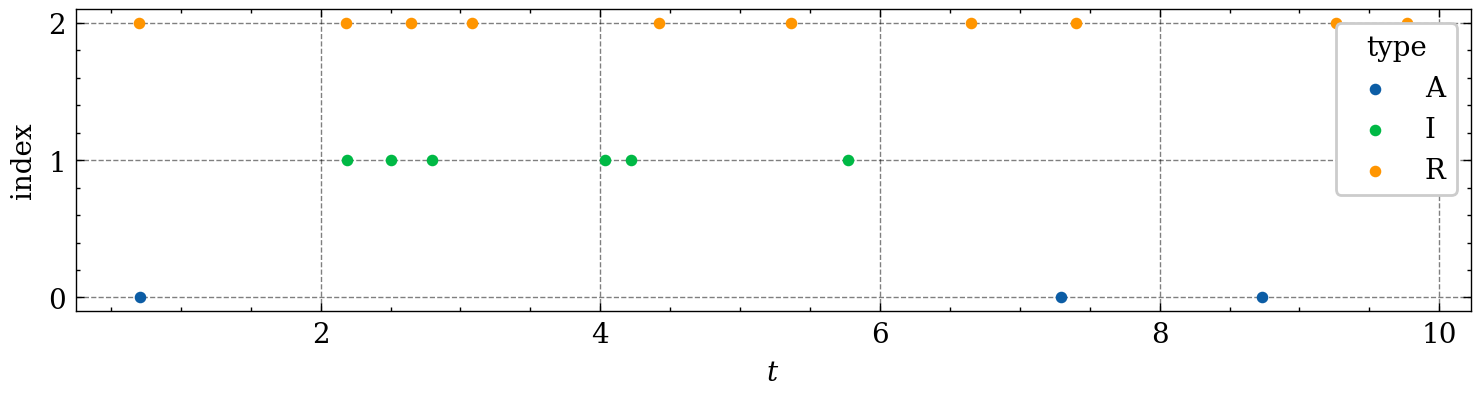

In [38]:
import scienceplots
import matplotlib.pyplot as plt
plt.style.use(['science','grid','no-latex'])


gen = Logic_Model_Generator()
data = gen.generate_data(num_sample=1,time_horizon=10)
A = data[0][0]
I = data[0][1]
R = data[0][2]


plt.figure(figsize=(9,2),dpi=200)
plt.scatter(A['time'][1:], 0*np.ones(shape=(len(A['time'])-1,)),s=10,label='A')
plt.scatter(I['time'][1:], np.ones(shape=(len(I['time'])-1,)),s=10,label='I')
plt.scatter(R['time'][1:], 2*np.ones(shape=(len(R['time'])-1,)),s=10,label='R')
plt.yticks([0,1,2]);
plt.xlabel('$t$'); plt.ylabel('index'); plt.legend(title='type')

In [91]:
import numpy as np
import itertools
import torch.nn as nn
from torch.autograd import Variable
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
##################################################################

class Logic_Model(nn.Module):

    # for example, consider three rules:
    # A and B and Equal(A,B), and Before(A, D), then D;
    # C and Before(C, Not D), then  Not D
    # D Then  E, and Equal(D, E)
    # note that define the temporal predicates as compact as possible

    def __init__(self):

        '''
    We have
        1. 3 predicates: A(t), I(t), R(t)
        2. 3 rules
    '''


    # for example, consider three rules:
    # A and B and Equal(A,B), and Before(A, D), then D;
    # C and Before(C,Not D), then Not D
    # D Then E, and Equal(D, E)
    # note that define the temporal predicates as compact as possible

    def __init__(self):

        ### the following parameters are used to manually define the logic rules
        self.num_predicate = 3                  # num_predicate is same as num_node
        self.num_formula = 3                    # num of prespecified logic rules
        self.BEFORE = 'BEFORE'
        self.EQUAL = 'EQUAL'
        self.AFTER = 'AFTER'
        self.Time_tolerance = 0.3               
        self.body_predicate_set = []                        # the index set of all body predicates
        self.mental_predicate_set = []
        self.action_predicate_set = [0, 1, 2]
        self.head_predicate_set = [0, 1, 2]     # the index set of all head predicates
        self.decay_rate = 1                                 # decay kernel
        self.integral_resolution = 0.03

        ### the following parameters are used to generate synthetic data
        ### for the learning part, the following is used to claim variables
        ### self.model_parameter = {0:{},1:{},...,6:{}}
        self.model_parameter = {}


        head_predicate_idx = 0
        self.model_parameter[head_predicate_idx] = {}
        self.model_parameter[head_predicate_idx]['base'] = torch.autograd.Variable((-torch.rand(size=(1,))).double(), requires_grad=True)

        formula_idx = 0
        self.model_parameter[head_predicate_idx][formula_idx] = {}
        self.model_parameter[head_predicate_idx][formula_idx]['weight'] = torch.autograd.Variable((torch.rand(size=(1,))).double(), requires_grad=True)


        head_predicate_idx = 1
        self.model_parameter[head_predicate_idx] = {}
        self.model_parameter[head_predicate_idx]['base'] = torch.autograd.Variable((-torch.rand(size=(1,))).double(), requires_grad=True)

        formula_idx = 0
        self.model_parameter[head_predicate_idx][formula_idx] = {}
        self.model_parameter[head_predicate_idx][formula_idx]['weight'] = torch.autograd.Variable((torch.rand(size=(1,))).double(), requires_grad=True)


        head_predicate_idx = 2
        self.model_parameter[head_predicate_idx] = {}
        self.model_parameter[head_predicate_idx]['base'] = torch.autograd.Variable((-torch.rand(size=(1,))).double(), requires_grad=True)

        formula_idx = 0
        self.model_parameter[head_predicate_idx][formula_idx] = {}
        self.model_parameter[head_predicate_idx][formula_idx]['weight'] = torch.autograd.Variable((torch.rand(size=(1,))).double(), requires_grad=True)

        
        #NOTE: set the content of logic rules
        self.logic_template = self.logic_rule()

    def logic_rule(self):
        # encode rule information
        '''
        This function encodes the content of logic rules
        logic_template = {0:{},1:{},2:{}}
        '''
        logic_template = {}


        head_predicate_idx = 0
        logic_template[head_predicate_idx] = {} # here 0 is the index of the head predicate; we could have multiple head predicates

        #NOTE: rule content: (\neg i \to a) and (before(neg i, a))
        formula_idx = 0
        logic_template[head_predicate_idx][formula_idx] = {}
        logic_template[head_predicate_idx][formula_idx]['body_predicate_idx'] = [1]
        logic_template[head_predicate_idx][formula_idx]['body_predicate_sign'] = [-1]  # use 1 to indicate True; use -1 to indicate False
        logic_template[head_predicate_idx][formula_idx]['head_predicate_sign'] = [0]
        logic_template[head_predicate_idx][formula_idx]['temporal_relation_idx'] = [[1, 0]]
        logic_template[head_predicate_idx][formula_idx]['temporal_relation_type'] = [self.BEFORE]


        head_predicate_idx = 1
        logic_template[head_predicate_idx] = {}  # here 1 is the index of the head predicate; we could have multiple head predicates

        #NOTE: rule content: (i and \neg r \to i') and (before(i,i') and before(\neg r,i'))
        formula_idx = 0
        logic_template[head_predicate_idx][formula_idx] = {}
        logic_template[head_predicate_idx][formula_idx]['body_predicate_idx'] = [1, 2]
        logic_template[head_predicate_idx][formula_idx]['body_predicate_sign'] = [1, -1]
        logic_template[head_predicate_idx][formula_idx]['head_predicate_sign'] = [1]
        logic_template[head_predicate_idx][formula_idx]['temporal_relation_idx'] = [[1, 1], [2, 1]]
        logic_template[head_predicate_idx][formula_idx]['temporal_relation_type'] = [self.BEFORE, self.BEFORE]


        head_predicate_idx = 2
        logic_template[head_predicate_idx] = {}  # here 2 is the index of the head predicate; we could have multiple head predicates

        #NOTE: rule content: (a or i \to r) and (before(a,r) and before(i,r))
        formula_idx = 0
        logic_template[head_predicate_idx][formula_idx] = {}
        logic_template[head_predicate_idx][formula_idx]['body_predicate_idx'] = [0, 1]
        logic_template[head_predicate_idx][formula_idx]['body_predicate_sign'] = [1, 1]
        logic_template[head_predicate_idx][formula_idx]['head_predicate_sign'] = [1]
        logic_template[head_predicate_idx][formula_idx]['temporal_relation_idx'] = [[0, 2], [1, 2]]
        logic_template[head_predicate_idx][formula_idx]['temporal_relation_type'] = [self.BEFORE, self.BEFORE]


        return logic_template

    def intensity(self, cur_time, head_predicate_idx, history):
        feature_formula = []
        weight_formula = []
        effect_formula = []
        #TODO: Check if the head_prediate is a mental predicate
        flag = 0

        for formula_idx in list(self.logic_template[head_predicate_idx].keys()):
            weight_formula.append(self.model_parameter[head_predicate_idx][formula_idx]['weight'])

            feature_formula.append(self.get_feature(cur_time=cur_time, head_predicate_idx=head_predicate_idx,
                                                    history=history, template=self.logic_template[head_predicate_idx][formula_idx], flag=flag))
            effect_formula.append(self.get_formula_effect(cur_time=cur_time, head_predicate_idx=head_predicate_idx,
                                                       history=history, template=self.logic_template[head_predicate_idx][formula_idx]))
        intensity = torch.exp(torch.cat(weight_formula, dim=0)) * torch.cat(feature_formula, dim=0) * torch.cat(effect_formula, dim=0)
        intensity = self.model_parameter[head_predicate_idx]['base'] + torch.sum(intensity)
        intensity = torch.exp(intensity)

        #print('predicate:',head_predicate_idx, weight_formula)

        return intensity

    def get_feature(self, cur_time, head_predicate_idx, history, template, flag:int):
        #NOTE: flag: 0 or 1, denotes the head_predicate_idx is a mental or an action
        #NOTE: 0 for mental and 1 for action
        #NOTE: since for mental, we need to go through all the history information
        #NOTE: while for action, we only care about the current time information
        
        transition_time_dic = {}
        feature = torch.tensor([0], dtype=torch.float64)
        for idx, body_predicate_idx in enumerate(template['body_predicate_idx']):
            transition_time = np.array(history[body_predicate_idx]['time'])
            transition_state = np.array(history[body_predicate_idx]['state'])
            mask = (transition_time <= cur_time) * (transition_state == template['body_predicate_sign'][idx])
            transition_time_dic[body_predicate_idx] = transition_time[mask]
        transition_time_dic[head_predicate_idx] = [cur_time]
        ### get weights
        # compute features whenever any item of the transition_item_dic is nonempty
        history_transition_len = [len(i) for i in transition_time_dic.values()]
        if min(history_transition_len) > 0:
            # need to compute feature using logic rules
            time_combination = np.array(list(itertools.product(*transition_time_dic.values())))
            time_combination_dic = {}
            for i, idx in enumerate(list(transition_time_dic.keys())):
                #TODO: this is where we distinguish mental and action
                time_combination_dic[idx] = time_combination[:, i] if flag == 0 else time_combination[-1, i]
            temporal_kernel = np.ones(len(time_combination))
            for idx, temporal_relation_idx in enumerate(template['temporal_relation_idx']):       
                #TODO: checkpoint
                #print('head_predicate_idx: {}; temporal_relation_idx[0]: {}, temporal_relation_idx[1]: {}'.format(head_predicate_idx, temporal_relation_idx[0], temporal_relation_idx[1]))
                #print('temporal combination dict: {}'.format(time_combination_dic))
         
                time_difference = time_combination_dic[temporal_relation_idx[0]] - time_combination_dic[temporal_relation_idx[1]]
                if template['temporal_relation_type'][idx] == 'BEFORE':
                    temporal_kernel *= (time_difference < - self.Time_tolerance) * np.exp(-self.decay_rate *(cur_time - time_combination_dic[temporal_relation_idx[0]]))
                if template['temporal_relation_type'][idx] == 'EQUAL':
                    temporal_kernel *= (abs(time_difference) <= self.Time_tolerance) * np.exp(-self.decay_rate*(cur_time - time_combination_dic[temporal_relation_idx[0]]))
                if template['temporal_relation_type'][idx] == 'AFTER':
                    temporal_kernel *= (time_difference > self.Time_tolerance) * np.exp(-self.decay_rate*(cur_time - time_combination_dic[temporal_relation_idx[1]]))
            feature = torch.tensor([np.sum(temporal_kernel)], dtype=torch.float64)
        return feature

    def get_formula_effect(self, cur_time, head_predicate_idx, history, template):
        ## Note this part is very important!! For generator, this should be np.sum(cur_time > head_transition_time) - 1
        ## Since at the transition times, choose the intensity function right before the transition time
        return torch.tensor([1], dtype=torch.float64)

    def log_likelihood(self, dataset, sample_ID_batch, T_max):
        '''
        This function calculates the log-likehood given the dataset
        log-likelihood = \sum log(intensity(transition_time)) + int_0^T intensity dt

        Parameters:
            dataset: 
            sample_ID_batch: list
            T_max:
        '''
        log_likelihood = torch.tensor([0], dtype=torch.float64)
        # iterate over samples
        for sample_ID in sample_ID_batch:
            # iterate over head predicates; each predicate corresponds to one intensity
            data_sample = dataset[sample_ID]
            for head_predicate_idx in self.head_predicate_set:
                #NOTE: compute the summation of log intensities at the transition times
                intensity_log_sum = self.intensity_log_sum(head_predicate_idx, data_sample)
                #NOTE: compute the integration of intensity function over the time horizon
                intensity_integral = self.intensity_integral(head_predicate_idx, data_sample, T_max)
                log_likelihood += (intensity_log_sum - intensity_integral)
        return log_likelihood

    def intensity_log_sum(self, head_predicate_idx, data_sample):
        intensity_transition = []
        for t in data_sample[head_predicate_idx]['time'][1:]:
            #NOTE: compute the intensity at transition times
            cur_intensity:torch.tensor = self.intensity(t, head_predicate_idx, data_sample)
            intensity_transition.append(cur_intensity)
        if len(intensity_transition) == 0: # only survival term, no event happens
            log_sum = torch.tensor([0], dtype=torch.float64)
        else:
            log_sum = torch.sum(torch.log(torch.cat(intensity_transition, dim=0)))
        return log_sum

    def intensity_integral(self, head_predicate_idx, data_sample, T_max):
        start_time = 0
        end_time = T_max
        intensity_grid = []
        for t in np.arange(start_time, end_time, self.integral_resolution):
            #NOTE: evaluate the intensity values at the chosen time points
            cur_intensity:torch.Tensor = self.intensity(t, head_predicate_idx, data_sample)
            intensity_grid.append(cur_intensity)
        #NOTE: approximately calculate the integral
        integral = torch.sum(torch.cat(intensity_grid, dim=0) * self.integral_resolution)
        return integral

    ### the following functions are for optimization
    def optimize_log_likelihood(self, dataset, sample_ID_batch, T_max, optimizer):
        optimizer.zero_grad()  # set gradient zero at the start of a new mini-batch
        #TODO: the loss function is just the -log-likelihood, since minimize the loss is equivalent to maximize the log-likelihood
        loss = -self.log_likelihood(dataset, sample_ID_batch, T_max)
        loss.backward()
        optimizer.step()
        return loss

In [92]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('train on {}'.format(device))

import time
from tqdm import *

#TODO: learn the model with complete data

logic_model_generator = Logic_Model_Generator()

#NOTE: some parameters
num_samples = 100
time_horizon = 1
batch_size = 25
num_batch = num_samples / batch_size
num_iter = 300
lr = 0.008

#TODO: generate data
data = logic_model_generator.generate_data(num_sample=num_samples, time_horizon=time_horizon)
print('data generated!!!')
#data = np.load('data.npy', allow_pickle='TRUE').item()  # load the generated data


#TODO: learn the model with complete data
logic_model = Logic_Model()
losses = []                     #NOTE: store the loss
model_parameters = [logic_model.model_parameter[0]['base'],
                    logic_model.model_parameter[0][0]['weight'],
                    logic_model.model_parameter[1]['base'],
                    logic_model.model_parameter[1][0]['weight'],
                    logic_model.model_parameter[2]['base'],
                    logic_model.model_parameter[2][0]['weight'],
                    ]

optimizer = optim.Adam(params=model_parameters, lr=lr)
for iter in tqdm(range(num_iter)):
    for batch_idx in tqdm(np.arange(0, num_batch, 1)):
        indices = np.arange(batch_idx*batch_size, (batch_idx+1)*batch_size, 1)
        loss = logic_model.optimize_log_likelihood(data, indices, time_horizon, optimizer)
        losses.append(loss)
    print('loss is', loss.detach().numpy())
    print('Model parameter is', logic_model.model_parameter)

train on cuda
data generated!!!


  0%|          | 1/300 [00:02<13:11,  2.65s/it]

loss is [66.53046855]
Model parameter is {0: {'base': tensor([-0.5404], dtype=torch.float64, requires_grad=True), 0: {'weight': tensor([0.5435], dtype=torch.float64, requires_grad=True)}}, 1: {'base': tensor([-0.2027], dtype=torch.float64, requires_grad=True), 0: {'weight': tensor([0.1136], dtype=torch.float64, requires_grad=True)}}, 2: {'base': tensor([-0.8080], dtype=torch.float64, requires_grad=True), 0: {'weight': tensor([0.5433], dtype=torch.float64, requires_grad=True)}}}


  1%|          | 2/300 [00:05<12:48,  2.58s/it]

loss is [66.28647276]
Model parameter is {0: {'base': tensor([-0.5549], dtype=torch.float64, requires_grad=True), 0: {'weight': tensor([0.5435], dtype=torch.float64, requires_grad=True)}}, 1: {'base': tensor([-0.2254], dtype=torch.float64, requires_grad=True), 0: {'weight': tensor([0.1136], dtype=torch.float64, requires_grad=True)}}, 2: {'base': tensor([-0.7797], dtype=torch.float64, requires_grad=True), 0: {'weight': tensor([0.5503], dtype=torch.float64, requires_grad=True)}}}


  1%|          | 3/300 [00:07<11:53,  2.40s/it]

loss is [66.07112708]
Model parameter is {0: {'base': tensor([-0.5688], dtype=torch.float64, requires_grad=True), 0: {'weight': tensor([0.5435], dtype=torch.float64, requires_grad=True)}}, 1: {'base': tensor([-0.2475], dtype=torch.float64, requires_grad=True), 0: {'weight': tensor([0.1136], dtype=torch.float64, requires_grad=True)}}, 2: {'base': tensor([-0.7521], dtype=torch.float64, requires_grad=True), 0: {'weight': tensor([0.5554], dtype=torch.float64, requires_grad=True)}}}


  1%|▏         | 4/300 [00:09<11:25,  2.32s/it]

loss is [65.88609366]
Model parameter is {0: {'base': tensor([-0.5820], dtype=torch.float64, requires_grad=True), 0: {'weight': tensor([0.5435], dtype=torch.float64, requires_grad=True)}}, 1: {'base': tensor([-0.2685], dtype=torch.float64, requires_grad=True), 0: {'weight': tensor([0.1136], dtype=torch.float64, requires_grad=True)}}, 2: {'base': tensor([-0.7251], dtype=torch.float64, requires_grad=True), 0: {'weight': tensor([0.5594], dtype=torch.float64, requires_grad=True)}}}


  2%|▏         | 5/300 [00:11<11:11,  2.28s/it]

loss is [65.7304239]
Model parameter is {0: {'base': tensor([-0.5944], dtype=torch.float64, requires_grad=True), 0: {'weight': tensor([0.5435], dtype=torch.float64, requires_grad=True)}}, 1: {'base': tensor([-0.2880], dtype=torch.float64, requires_grad=True), 0: {'weight': tensor([0.1136], dtype=torch.float64, requires_grad=True)}}, 2: {'base': tensor([-0.6990], dtype=torch.float64, requires_grad=True), 0: {'weight': tensor([0.5624], dtype=torch.float64, requires_grad=True)}}}


  2%|▏         | 6/300 [00:13<11:01,  2.25s/it]

loss is [65.60203463]
Model parameter is {0: {'base': tensor([-0.6060], dtype=torch.float64, requires_grad=True), 0: {'weight': tensor([0.5435], dtype=torch.float64, requires_grad=True)}}, 1: {'base': tensor([-0.3056], dtype=torch.float64, requires_grad=True), 0: {'weight': tensor([0.1136], dtype=torch.float64, requires_grad=True)}}, 2: {'base': tensor([-0.6738], dtype=torch.float64, requires_grad=True), 0: {'weight': tensor([0.5644], dtype=torch.float64, requires_grad=True)}}}


  2%|▏         | 7/300 [00:16<10:54,  2.23s/it]

loss is [65.49822417]
Model parameter is {0: {'base': tensor([-0.6166], dtype=torch.float64, requires_grad=True), 0: {'weight': tensor([0.5435], dtype=torch.float64, requires_grad=True)}}, 1: {'base': tensor([-0.3213], dtype=torch.float64, requires_grad=True), 0: {'weight': tensor([0.1136], dtype=torch.float64, requires_grad=True)}}, 2: {'base': tensor([-0.6497], dtype=torch.float64, requires_grad=True), 0: {'weight': tensor([0.5654], dtype=torch.float64, requires_grad=True)}}}


  3%|▎         | 8/300 [00:18<10:52,  2.24s/it]

loss is [65.41598524]
Model parameter is {0: {'base': tensor([-0.6264], dtype=torch.float64, requires_grad=True), 0: {'weight': tensor([0.5435], dtype=torch.float64, requires_grad=True)}}, 1: {'base': tensor([-0.3351], dtype=torch.float64, requires_grad=True), 0: {'weight': tensor([0.1136], dtype=torch.float64, requires_grad=True)}}, 2: {'base': tensor([-0.6268], dtype=torch.float64, requires_grad=True), 0: {'weight': tensor([0.5655], dtype=torch.float64, requires_grad=True)}}}


  3%|▎         | 9/300 [00:20<10:47,  2.23s/it]

loss is [65.35223101]
Model parameter is {0: {'base': tensor([-0.6354], dtype=torch.float64, requires_grad=True), 0: {'weight': tensor([0.5435], dtype=torch.float64, requires_grad=True)}}, 1: {'base': tensor([-0.3470], dtype=torch.float64, requires_grad=True), 0: {'weight': tensor([0.1136], dtype=torch.float64, requires_grad=True)}}, 2: {'base': tensor([-0.6052], dtype=torch.float64, requires_grad=True), 0: {'weight': tensor([0.5647], dtype=torch.float64, requires_grad=True)}}}


  3%|▎         | 10/300 [00:22<10:41,  2.21s/it]

loss is [65.30395881]
Model parameter is {0: {'base': tensor([-0.6435], dtype=torch.float64, requires_grad=True), 0: {'weight': tensor([0.5435], dtype=torch.float64, requires_grad=True)}}, 1: {'base': tensor([-0.3570], dtype=torch.float64, requires_grad=True), 0: {'weight': tensor([0.1136], dtype=torch.float64, requires_grad=True)}}, 2: {'base': tensor([-0.5850], dtype=torch.float64, requires_grad=True), 0: {'weight': tensor([0.5629], dtype=torch.float64, requires_grad=True)}}}


  4%|▎         | 11/300 [00:24<10:36,  2.20s/it]

loss is [65.26836097]
Model parameter is {0: {'base': tensor([-0.6509], dtype=torch.float64, requires_grad=True), 0: {'weight': tensor([0.5435], dtype=torch.float64, requires_grad=True)}}, 1: {'base': tensor([-0.3654], dtype=torch.float64, requires_grad=True), 0: {'weight': tensor([0.1136], dtype=torch.float64, requires_grad=True)}}, 2: {'base': tensor([-0.5662], dtype=torch.float64, requires_grad=True), 0: {'weight': tensor([0.5603], dtype=torch.float64, requires_grad=True)}}}


  4%|▍         | 12/300 [00:27<10:41,  2.23s/it]

loss is [65.24289247]
Model parameter is {0: {'base': tensor([-0.6575], dtype=torch.float64, requires_grad=True), 0: {'weight': tensor([0.5435], dtype=torch.float64, requires_grad=True)}}, 1: {'base': tensor([-0.3723], dtype=torch.float64, requires_grad=True), 0: {'weight': tensor([0.1136], dtype=torch.float64, requires_grad=True)}}, 2: {'base': tensor([-0.5489], dtype=torch.float64, requires_grad=True), 0: {'weight': tensor([0.5568], dtype=torch.float64, requires_grad=True)}}}


  4%|▍         | 13/300 [00:29<10:33,  2.21s/it]

loss is [65.22530559]
Model parameter is {0: {'base': tensor([-0.6635], dtype=torch.float64, requires_grad=True), 0: {'weight': tensor([0.5435], dtype=torch.float64, requires_grad=True)}}, 1: {'base': tensor([-0.3777], dtype=torch.float64, requires_grad=True), 0: {'weight': tensor([0.1136], dtype=torch.float64, requires_grad=True)}}, 2: {'base': tensor([-0.5331], dtype=torch.float64, requires_grad=True), 0: {'weight': tensor([0.5526], dtype=torch.float64, requires_grad=True)}}}


  5%|▍         | 14/300 [00:31<10:29,  2.20s/it]

loss is [65.21366117]
Model parameter is {0: {'base': tensor([-0.6689], dtype=torch.float64, requires_grad=True), 0: {'weight': tensor([0.5435], dtype=torch.float64, requires_grad=True)}}, 1: {'base': tensor([-0.3821], dtype=torch.float64, requires_grad=True), 0: {'weight': tensor([0.1136], dtype=torch.float64, requires_grad=True)}}, 2: {'base': tensor([-0.5187], dtype=torch.float64, requires_grad=True), 0: {'weight': tensor([0.5477], dtype=torch.float64, requires_grad=True)}}}


  5%|▌         | 15/300 [00:33<10:41,  2.25s/it]

loss is [65.20632398]
Model parameter is {0: {'base': tensor([-0.6737], dtype=torch.float64, requires_grad=True), 0: {'weight': tensor([0.5435], dtype=torch.float64, requires_grad=True)}}, 1: {'base': tensor([-0.3854], dtype=torch.float64, requires_grad=True), 0: {'weight': tensor([0.1136], dtype=torch.float64, requires_grad=True)}}, 2: {'base': tensor([-0.5058], dtype=torch.float64, requires_grad=True), 0: {'weight': tensor([0.5421], dtype=torch.float64, requires_grad=True)}}}


  5%|▌         | 16/300 [00:36<10:46,  2.28s/it]

loss is [65.20194788]
Model parameter is {0: {'base': tensor([-0.6780], dtype=torch.float64, requires_grad=True), 0: {'weight': tensor([0.5435], dtype=torch.float64, requires_grad=True)}}, 1: {'base': tensor([-0.3879], dtype=torch.float64, requires_grad=True), 0: {'weight': tensor([0.1136], dtype=torch.float64, requires_grad=True)}}, 2: {'base': tensor([-0.4943], dtype=torch.float64, requires_grad=True), 0: {'weight': tensor([0.5360], dtype=torch.float64, requires_grad=True)}}}


  6%|▌         | 17/300 [00:38<10:45,  2.28s/it]

loss is [65.19945397]
Model parameter is {0: {'base': tensor([-0.6819], dtype=torch.float64, requires_grad=True), 0: {'weight': tensor([0.5435], dtype=torch.float64, requires_grad=True)}}, 1: {'base': tensor([-0.3897], dtype=torch.float64, requires_grad=True), 0: {'weight': tensor([0.1136], dtype=torch.float64, requires_grad=True)}}, 2: {'base': tensor([-0.4841], dtype=torch.float64, requires_grad=True), 0: {'weight': tensor([0.5295], dtype=torch.float64, requires_grad=True)}}}


  6%|▌         | 18/300 [00:40<10:46,  2.29s/it]

loss is [65.19800439]
Model parameter is {0: {'base': tensor([-0.6853], dtype=torch.float64, requires_grad=True), 0: {'weight': tensor([0.5435], dtype=torch.float64, requires_grad=True)}}, 1: {'base': tensor([-0.3910], dtype=torch.float64, requires_grad=True), 0: {'weight': tensor([0.1136], dtype=torch.float64, requires_grad=True)}}, 2: {'base': tensor([-0.4751], dtype=torch.float64, requires_grad=True), 0: {'weight': tensor([0.5225], dtype=torch.float64, requires_grad=True)}}}


  6%|▋         | 19/300 [00:43<11:01,  2.36s/it]

loss is [65.19697319]
Model parameter is {0: {'base': tensor([-0.6883], dtype=torch.float64, requires_grad=True), 0: {'weight': tensor([0.5435], dtype=torch.float64, requires_grad=True)}}, 1: {'base': tensor([-0.3919], dtype=torch.float64, requires_grad=True), 0: {'weight': tensor([0.1136], dtype=torch.float64, requires_grad=True)}}, 2: {'base': tensor([-0.4674], dtype=torch.float64, requires_grad=True), 0: {'weight': tensor([0.5152], dtype=torch.float64, requires_grad=True)}}}


  7%|▋         | 20/300 [00:45<10:58,  2.35s/it]

loss is [65.19591592]
Model parameter is {0: {'base': tensor([-0.6911], dtype=torch.float64, requires_grad=True), 0: {'weight': tensor([0.5435], dtype=torch.float64, requires_grad=True)}}, 1: {'base': tensor([-0.3924], dtype=torch.float64, requires_grad=True), 0: {'weight': tensor([0.1136], dtype=torch.float64, requires_grad=True)}}, 2: {'base': tensor([-0.4607], dtype=torch.float64, requires_grad=True), 0: {'weight': tensor([0.5077], dtype=torch.float64, requires_grad=True)}}}


  7%|▋         | 21/300 [00:47<10:45,  2.31s/it]

loss is [65.19453897]
Model parameter is {0: {'base': tensor([-0.6935], dtype=torch.float64, requires_grad=True), 0: {'weight': tensor([0.5435], dtype=torch.float64, requires_grad=True)}}, 1: {'base': tensor([-0.3927], dtype=torch.float64, requires_grad=True), 0: {'weight': tensor([0.1136], dtype=torch.float64, requires_grad=True)}}, 2: {'base': tensor([-0.4550], dtype=torch.float64, requires_grad=True), 0: {'weight': tensor([0.5000], dtype=torch.float64, requires_grad=True)}}}


  7%|▋         | 22/300 [00:50<10:33,  2.28s/it]

loss is [65.19267015]
Model parameter is {0: {'base': tensor([-0.6956], dtype=torch.float64, requires_grad=True), 0: {'weight': tensor([0.5435], dtype=torch.float64, requires_grad=True)}}, 1: {'base': tensor([-0.3929], dtype=torch.float64, requires_grad=True), 0: {'weight': tensor([0.1136], dtype=torch.float64, requires_grad=True)}}, 2: {'base': tensor([-0.4501], dtype=torch.float64, requires_grad=True), 0: {'weight': tensor([0.4922], dtype=torch.float64, requires_grad=True)}}}


  8%|▊         | 23/300 [00:52<10:15,  2.22s/it]

loss is [65.19023122]
Model parameter is {0: {'base': tensor([-0.6975], dtype=torch.float64, requires_grad=True), 0: {'weight': tensor([0.5435], dtype=torch.float64, requires_grad=True)}}, 1: {'base': tensor([-0.3928], dtype=torch.float64, requires_grad=True), 0: {'weight': tensor([0.1136], dtype=torch.float64, requires_grad=True)}}, 2: {'base': tensor([-0.4461], dtype=torch.float64, requires_grad=True), 0: {'weight': tensor([0.4843], dtype=torch.float64, requires_grad=True)}}}


  8%|▊         | 24/300 [00:54<10:25,  2.26s/it]

loss is [65.18721344]
Model parameter is {0: {'base': tensor([-0.6992], dtype=torch.float64, requires_grad=True), 0: {'weight': tensor([0.5435], dtype=torch.float64, requires_grad=True)}}, 1: {'base': tensor([-0.3928], dtype=torch.float64, requires_grad=True), 0: {'weight': tensor([0.1136], dtype=torch.float64, requires_grad=True)}}, 2: {'base': tensor([-0.4427], dtype=torch.float64, requires_grad=True), 0: {'weight': tensor([0.4764], dtype=torch.float64, requires_grad=True)}}}


  8%|▊         | 25/300 [00:56<10:11,  2.22s/it]

loss is [65.18365647]
Model parameter is {0: {'base': tensor([-0.7007], dtype=torch.float64, requires_grad=True), 0: {'weight': tensor([0.5435], dtype=torch.float64, requires_grad=True)}}, 1: {'base': tensor([-0.3926], dtype=torch.float64, requires_grad=True), 0: {'weight': tensor([0.1136], dtype=torch.float64, requires_grad=True)}}, 2: {'base': tensor([-0.4398], dtype=torch.float64, requires_grad=True), 0: {'weight': tensor([0.4685], dtype=torch.float64, requires_grad=True)}}}


  9%|▊         | 26/300 [00:59<10:32,  2.31s/it]

loss is [65.17963089]
Model parameter is {0: {'base': tensor([-0.7021], dtype=torch.float64, requires_grad=True), 0: {'weight': tensor([0.5435], dtype=torch.float64, requires_grad=True)}}, 1: {'base': tensor([-0.3925], dtype=torch.float64, requires_grad=True), 0: {'weight': tensor([0.1136], dtype=torch.float64, requires_grad=True)}}, 2: {'base': tensor([-0.4375], dtype=torch.float64, requires_grad=True), 0: {'weight': tensor([0.4606], dtype=torch.float64, requires_grad=True)}}}


  9%|▉         | 27/300 [01:02<11:42,  2.57s/it]

loss is [65.17522424]
Model parameter is {0: {'base': tensor([-0.7033], dtype=torch.float64, requires_grad=True), 0: {'weight': tensor([0.5435], dtype=torch.float64, requires_grad=True)}}, 1: {'base': tensor([-0.3923], dtype=torch.float64, requires_grad=True), 0: {'weight': tensor([0.1136], dtype=torch.float64, requires_grad=True)}}, 2: {'base': tensor([-0.4357], dtype=torch.float64, requires_grad=True), 0: {'weight': tensor([0.4529], dtype=torch.float64, requires_grad=True)}}}


  9%|▉         | 28/300 [01:06<13:06,  2.89s/it]

loss is [65.17053047]
Model parameter is {0: {'base': tensor([-0.7043], dtype=torch.float64, requires_grad=True), 0: {'weight': tensor([0.5435], dtype=torch.float64, requires_grad=True)}}, 1: {'base': tensor([-0.3921], dtype=torch.float64, requires_grad=True), 0: {'weight': tensor([0.1136], dtype=torch.float64, requires_grad=True)}}, 2: {'base': tensor([-0.4341], dtype=torch.float64, requires_grad=True), 0: {'weight': tensor([0.4452], dtype=torch.float64, requires_grad=True)}}}


 10%|▉         | 29/300 [01:08<12:57,  2.87s/it]

loss is [65.1656422]
Model parameter is {0: {'base': tensor([-0.7053], dtype=torch.float64, requires_grad=True), 0: {'weight': tensor([0.5435], dtype=torch.float64, requires_grad=True)}}, 1: {'base': tensor([-0.3920], dtype=torch.float64, requires_grad=True), 0: {'weight': tensor([0.1136], dtype=torch.float64, requires_grad=True)}}, 2: {'base': tensor([-0.4329], dtype=torch.float64, requires_grad=True), 0: {'weight': tensor([0.4376], dtype=torch.float64, requires_grad=True)}}}


 10%|█         | 30/300 [01:11<12:53,  2.86s/it]

loss is [65.16064557]
Model parameter is {0: {'base': tensor([-0.7061], dtype=torch.float64, requires_grad=True), 0: {'weight': tensor([0.5435], dtype=torch.float64, requires_grad=True)}}, 1: {'base': tensor([-0.3918], dtype=torch.float64, requires_grad=True), 0: {'weight': tensor([0.1136], dtype=torch.float64, requires_grad=True)}}, 2: {'base': tensor([-0.4319], dtype=torch.float64, requires_grad=True), 0: {'weight': tensor([0.4302], dtype=torch.float64, requires_grad=True)}}}


 10%|█         | 31/300 [01:14<12:40,  2.83s/it]

loss is [65.15561704]
Model parameter is {0: {'base': tensor([-0.7068], dtype=torch.float64, requires_grad=True), 0: {'weight': tensor([0.5435], dtype=torch.float64, requires_grad=True)}}, 1: {'base': tensor([-0.3917], dtype=torch.float64, requires_grad=True), 0: {'weight': tensor([0.1136], dtype=torch.float64, requires_grad=True)}}, 2: {'base': tensor([-0.4311], dtype=torch.float64, requires_grad=True), 0: {'weight': tensor([0.4230], dtype=torch.float64, requires_grad=True)}}}


 11%|█         | 32/300 [01:16<12:00,  2.69s/it]

loss is [65.15062175]
Model parameter is {0: {'base': tensor([-0.7075], dtype=torch.float64, requires_grad=True), 0: {'weight': tensor([0.5435], dtype=torch.float64, requires_grad=True)}}, 1: {'base': tensor([-0.3916], dtype=torch.float64, requires_grad=True), 0: {'weight': tensor([0.1136], dtype=torch.float64, requires_grad=True)}}, 2: {'base': tensor([-0.4305], dtype=torch.float64, requires_grad=True), 0: {'weight': tensor([0.4159], dtype=torch.float64, requires_grad=True)}}}


 11%|█         | 33/300 [01:18<11:08,  2.50s/it]

loss is [65.14571306]
Model parameter is {0: {'base': tensor([-0.7081], dtype=torch.float64, requires_grad=True), 0: {'weight': tensor([0.5435], dtype=torch.float64, requires_grad=True)}}, 1: {'base': tensor([-0.3915], dtype=torch.float64, requires_grad=True), 0: {'weight': tensor([0.1136], dtype=torch.float64, requires_grad=True)}}, 2: {'base': tensor([-0.4300], dtype=torch.float64, requires_grad=True), 0: {'weight': tensor([0.4089], dtype=torch.float64, requires_grad=True)}}}


 11%|█▏        | 34/300 [01:21<11:20,  2.56s/it]

loss is [65.14093288]
Model parameter is {0: {'base': tensor([-0.7086], dtype=torch.float64, requires_grad=True), 0: {'weight': tensor([0.5435], dtype=torch.float64, requires_grad=True)}}, 1: {'base': tensor([-0.3915], dtype=torch.float64, requires_grad=True), 0: {'weight': tensor([0.1136], dtype=torch.float64, requires_grad=True)}}, 2: {'base': tensor([-0.4296], dtype=torch.float64, requires_grad=True), 0: {'weight': tensor([0.4021], dtype=torch.float64, requires_grad=True)}}}


 12%|█▏        | 35/300 [01:23<10:55,  2.47s/it]

loss is [65.13631251]
Model parameter is {0: {'base': tensor([-0.7090], dtype=torch.float64, requires_grad=True), 0: {'weight': tensor([0.5435], dtype=torch.float64, requires_grad=True)}}, 1: {'base': tensor([-0.3914], dtype=torch.float64, requires_grad=True), 0: {'weight': tensor([0.1136], dtype=torch.float64, requires_grad=True)}}, 2: {'base': tensor([-0.4292], dtype=torch.float64, requires_grad=True), 0: {'weight': tensor([0.3955], dtype=torch.float64, requires_grad=True)}}}


 12%|█▏        | 36/300 [01:26<10:36,  2.41s/it]

loss is [65.13187385]
Model parameter is {0: {'base': tensor([-0.7094], dtype=torch.float64, requires_grad=True), 0: {'weight': tensor([0.5435], dtype=torch.float64, requires_grad=True)}}, 1: {'base': tensor([-0.3914], dtype=torch.float64, requires_grad=True), 0: {'weight': tensor([0.1136], dtype=torch.float64, requires_grad=True)}}, 2: {'base': tensor([-0.4289], dtype=torch.float64, requires_grad=True), 0: {'weight': tensor([0.3890], dtype=torch.float64, requires_grad=True)}}}


 12%|█▏        | 37/300 [01:28<10:13,  2.33s/it]

loss is [65.1276307]
Model parameter is {0: {'base': tensor([-0.7098], dtype=torch.float64, requires_grad=True), 0: {'weight': tensor([0.5435], dtype=torch.float64, requires_grad=True)}}, 1: {'base': tensor([-0.3913], dtype=torch.float64, requires_grad=True), 0: {'weight': tensor([0.1136], dtype=torch.float64, requires_grad=True)}}, 2: {'base': tensor([-0.4287], dtype=torch.float64, requires_grad=True), 0: {'weight': tensor([0.3827], dtype=torch.float64, requires_grad=True)}}}


 13%|█▎        | 38/300 [01:30<09:57,  2.28s/it]

loss is [65.12359008]
Model parameter is {0: {'base': tensor([-0.7101], dtype=torch.float64, requires_grad=True), 0: {'weight': tensor([0.5435], dtype=torch.float64, requires_grad=True)}}, 1: {'base': tensor([-0.3913], dtype=torch.float64, requires_grad=True), 0: {'weight': tensor([0.1136], dtype=torch.float64, requires_grad=True)}}, 2: {'base': tensor([-0.4285], dtype=torch.float64, requires_grad=True), 0: {'weight': tensor([0.3766], dtype=torch.float64, requires_grad=True)}}}


 13%|█▎        | 39/300 [01:32<10:09,  2.34s/it]

loss is [65.11975359]
Model parameter is {0: {'base': tensor([-0.7104], dtype=torch.float64, requires_grad=True), 0: {'weight': tensor([0.5435], dtype=torch.float64, requires_grad=True)}}, 1: {'base': tensor([-0.3913], dtype=torch.float64, requires_grad=True), 0: {'weight': tensor([0.1136], dtype=torch.float64, requires_grad=True)}}, 2: {'base': tensor([-0.4283], dtype=torch.float64, requires_grad=True), 0: {'weight': tensor([0.3705], dtype=torch.float64, requires_grad=True)}}}


 13%|█▎        | 40/300 [01:34<09:40,  2.23s/it]

loss is [65.11611849]
Model parameter is {0: {'base': tensor([-0.7106], dtype=torch.float64, requires_grad=True), 0: {'weight': tensor([0.5435], dtype=torch.float64, requires_grad=True)}}, 1: {'base': tensor([-0.3913], dtype=torch.float64, requires_grad=True), 0: {'weight': tensor([0.1136], dtype=torch.float64, requires_grad=True)}}, 2: {'base': tensor([-0.4281], dtype=torch.float64, requires_grad=True), 0: {'weight': tensor([0.3647], dtype=torch.float64, requires_grad=True)}}}


 14%|█▎        | 41/300 [01:36<09:18,  2.16s/it]

loss is [65.11267886]
Model parameter is {0: {'base': tensor([-0.7109], dtype=torch.float64, requires_grad=True), 0: {'weight': tensor([0.5435], dtype=torch.float64, requires_grad=True)}}, 1: {'base': tensor([-0.3913], dtype=torch.float64, requires_grad=True), 0: {'weight': tensor([0.1136], dtype=torch.float64, requires_grad=True)}}, 2: {'base': tensor([-0.4279], dtype=torch.float64, requires_grad=True), 0: {'weight': tensor([0.3589], dtype=torch.float64, requires_grad=True)}}}


 14%|█▍        | 42/300 [01:38<09:06,  2.12s/it]

loss is [65.10942644]
Model parameter is {0: {'base': tensor([-0.7111], dtype=torch.float64, requires_grad=True), 0: {'weight': tensor([0.5435], dtype=torch.float64, requires_grad=True)}}, 1: {'base': tensor([-0.3913], dtype=torch.float64, requires_grad=True), 0: {'weight': tensor([0.1136], dtype=torch.float64, requires_grad=True)}}, 2: {'base': tensor([-0.4278], dtype=torch.float64, requires_grad=True), 0: {'weight': tensor([0.3534], dtype=torch.float64, requires_grad=True)}}}


 14%|█▍        | 43/300 [01:40<08:57,  2.09s/it]

loss is [65.10635139]
Model parameter is {0: {'base': tensor([-0.7112], dtype=torch.float64, requires_grad=True), 0: {'weight': tensor([0.5435], dtype=torch.float64, requires_grad=True)}}, 1: {'base': tensor([-0.3913], dtype=torch.float64, requires_grad=True), 0: {'weight': tensor([0.1136], dtype=torch.float64, requires_grad=True)}}, 2: {'base': tensor([-0.4276], dtype=torch.float64, requires_grad=True), 0: {'weight': tensor([0.3479], dtype=torch.float64, requires_grad=True)}}}


 15%|█▍        | 44/300 [01:42<08:46,  2.06s/it]

loss is [65.10344298]
Model parameter is {0: {'base': tensor([-0.7114], dtype=torch.float64, requires_grad=True), 0: {'weight': tensor([0.5435], dtype=torch.float64, requires_grad=True)}}, 1: {'base': tensor([-0.3913], dtype=torch.float64, requires_grad=True), 0: {'weight': tensor([0.1136], dtype=torch.float64, requires_grad=True)}}, 2: {'base': tensor([-0.4275], dtype=torch.float64, requires_grad=True), 0: {'weight': tensor([0.3426], dtype=torch.float64, requires_grad=True)}}}


 15%|█▌        | 45/300 [01:44<08:43,  2.05s/it]

loss is [65.10069002]
Model parameter is {0: {'base': tensor([-0.7115], dtype=torch.float64, requires_grad=True), 0: {'weight': tensor([0.5435], dtype=torch.float64, requires_grad=True)}}, 1: {'base': tensor([-0.3913], dtype=torch.float64, requires_grad=True), 0: {'weight': tensor([0.1136], dtype=torch.float64, requires_grad=True)}}, 2: {'base': tensor([-0.4273], dtype=torch.float64, requires_grad=True), 0: {'weight': tensor([0.3373], dtype=torch.float64, requires_grad=True)}}}


 15%|█▌        | 46/300 [01:47<09:06,  2.15s/it]

loss is [65.09808127]
Model parameter is {0: {'base': tensor([-0.7116], dtype=torch.float64, requires_grad=True), 0: {'weight': tensor([0.5435], dtype=torch.float64, requires_grad=True)}}, 1: {'base': tensor([-0.3913], dtype=torch.float64, requires_grad=True), 0: {'weight': tensor([0.1136], dtype=torch.float64, requires_grad=True)}}, 2: {'base': tensor([-0.4272], dtype=torch.float64, requires_grad=True), 0: {'weight': tensor([0.3322], dtype=torch.float64, requires_grad=True)}}}


 16%|█▌        | 47/300 [01:49<09:21,  2.22s/it]

loss is [65.09560574]
Model parameter is {0: {'base': tensor([-0.7118], dtype=torch.float64, requires_grad=True), 0: {'weight': tensor([0.5435], dtype=torch.float64, requires_grad=True)}}, 1: {'base': tensor([-0.3913], dtype=torch.float64, requires_grad=True), 0: {'weight': tensor([0.1136], dtype=torch.float64, requires_grad=True)}}, 2: {'base': tensor([-0.4270], dtype=torch.float64, requires_grad=True), 0: {'weight': tensor([0.3273], dtype=torch.float64, requires_grad=True)}}}


 16%|█▌        | 48/300 [01:52<10:07,  2.41s/it]

loss is [65.0932529]
Model parameter is {0: {'base': tensor([-0.7119], dtype=torch.float64, requires_grad=True), 0: {'weight': tensor([0.5435], dtype=torch.float64, requires_grad=True)}}, 1: {'base': tensor([-0.3913], dtype=torch.float64, requires_grad=True), 0: {'weight': tensor([0.1136], dtype=torch.float64, requires_grad=True)}}, 2: {'base': tensor([-0.4269], dtype=torch.float64, requires_grad=True), 0: {'weight': tensor([0.3224], dtype=torch.float64, requires_grad=True)}}}


 16%|█▋        | 49/300 [01:55<10:29,  2.51s/it]

loss is [65.09101281]
Model parameter is {0: {'base': tensor([-0.7119], dtype=torch.float64, requires_grad=True), 0: {'weight': tensor([0.5435], dtype=torch.float64, requires_grad=True)}}, 1: {'base': tensor([-0.3913], dtype=torch.float64, requires_grad=True), 0: {'weight': tensor([0.1136], dtype=torch.float64, requires_grad=True)}}, 2: {'base': tensor([-0.4267], dtype=torch.float64, requires_grad=True), 0: {'weight': tensor([0.3176], dtype=torch.float64, requires_grad=True)}}}


 17%|█▋        | 50/300 [01:57<10:19,  2.48s/it]

loss is [65.0888762]
Model parameter is {0: {'base': tensor([-0.7120], dtype=torch.float64, requires_grad=True), 0: {'weight': tensor([0.5435], dtype=torch.float64, requires_grad=True)}}, 1: {'base': tensor([-0.3913], dtype=torch.float64, requires_grad=True), 0: {'weight': tensor([0.1136], dtype=torch.float64, requires_grad=True)}}, 2: {'base': tensor([-0.4266], dtype=torch.float64, requires_grad=True), 0: {'weight': tensor([0.3130], dtype=torch.float64, requires_grad=True)}}}


 17%|█▋        | 51/300 [02:00<10:02,  2.42s/it]

loss is [65.08683452]
Model parameter is {0: {'base': tensor([-0.7121], dtype=torch.float64, requires_grad=True), 0: {'weight': tensor([0.5435], dtype=torch.float64, requires_grad=True)}}, 1: {'base': tensor([-0.3913], dtype=torch.float64, requires_grad=True), 0: {'weight': tensor([0.1136], dtype=torch.float64, requires_grad=True)}}, 2: {'base': tensor([-0.4265], dtype=torch.float64, requires_grad=True), 0: {'weight': tensor([0.3084], dtype=torch.float64, requires_grad=True)}}}


 17%|█▋        | 52/300 [02:02<09:53,  2.40s/it]

loss is [65.08487996]
Model parameter is {0: {'base': tensor([-0.7121], dtype=torch.float64, requires_grad=True), 0: {'weight': tensor([0.5435], dtype=torch.float64, requires_grad=True)}}, 1: {'base': tensor([-0.3913], dtype=torch.float64, requires_grad=True), 0: {'weight': tensor([0.1136], dtype=torch.float64, requires_grad=True)}}, 2: {'base': tensor([-0.4263], dtype=torch.float64, requires_grad=True), 0: {'weight': tensor([0.3039], dtype=torch.float64, requires_grad=True)}}}


 18%|█▊        | 53/300 [02:04<09:54,  2.41s/it]

loss is [65.08300545]
Model parameter is {0: {'base': tensor([-0.7122], dtype=torch.float64, requires_grad=True), 0: {'weight': tensor([0.5435], dtype=torch.float64, requires_grad=True)}}, 1: {'base': tensor([-0.3913], dtype=torch.float64, requires_grad=True), 0: {'weight': tensor([0.1136], dtype=torch.float64, requires_grad=True)}}, 2: {'base': tensor([-0.4262], dtype=torch.float64, requires_grad=True), 0: {'weight': tensor([0.2995], dtype=torch.float64, requires_grad=True)}}}


 18%|█▊        | 54/300 [02:07<09:55,  2.42s/it]

loss is [65.08120457]
Model parameter is {0: {'base': tensor([-0.7122], dtype=torch.float64, requires_grad=True), 0: {'weight': tensor([0.5435], dtype=torch.float64, requires_grad=True)}}, 1: {'base': tensor([-0.3913], dtype=torch.float64, requires_grad=True), 0: {'weight': tensor([0.1136], dtype=torch.float64, requires_grad=True)}}, 2: {'base': tensor([-0.4261], dtype=torch.float64, requires_grad=True), 0: {'weight': tensor([0.2952], dtype=torch.float64, requires_grad=True)}}}


 18%|█▊        | 55/300 [02:09<10:06,  2.48s/it]

loss is [65.07947158]
Model parameter is {0: {'base': tensor([-0.7123], dtype=torch.float64, requires_grad=True), 0: {'weight': tensor([0.5435], dtype=torch.float64, requires_grad=True)}}, 1: {'base': tensor([-0.3913], dtype=torch.float64, requires_grad=True), 0: {'weight': tensor([0.1136], dtype=torch.float64, requires_grad=True)}}, 2: {'base': tensor([-0.4259], dtype=torch.float64, requires_grad=True), 0: {'weight': tensor([0.2910], dtype=torch.float64, requires_grad=True)}}}


 19%|█▊        | 56/300 [02:12<10:14,  2.52s/it]

loss is [65.07780132]
Model parameter is {0: {'base': tensor([-0.7123], dtype=torch.float64, requires_grad=True), 0: {'weight': tensor([0.5435], dtype=torch.float64, requires_grad=True)}}, 1: {'base': tensor([-0.3913], dtype=torch.float64, requires_grad=True), 0: {'weight': tensor([0.1136], dtype=torch.float64, requires_grad=True)}}, 2: {'base': tensor([-0.4258], dtype=torch.float64, requires_grad=True), 0: {'weight': tensor([0.2869], dtype=torch.float64, requires_grad=True)}}}


 19%|█▉        | 57/300 [02:15<10:20,  2.55s/it]

loss is [65.07618918]
Model parameter is {0: {'base': tensor([-0.7123], dtype=torch.float64, requires_grad=True), 0: {'weight': tensor([0.5435], dtype=torch.float64, requires_grad=True)}}, 1: {'base': tensor([-0.3913], dtype=torch.float64, requires_grad=True), 0: {'weight': tensor([0.1136], dtype=torch.float64, requires_grad=True)}}, 2: {'base': tensor([-0.4257], dtype=torch.float64, requires_grad=True), 0: {'weight': tensor([0.2829], dtype=torch.float64, requires_grad=True)}}}


 19%|█▉        | 58/300 [02:17<10:18,  2.56s/it]

loss is [65.07463104]
Model parameter is {0: {'base': tensor([-0.7124], dtype=torch.float64, requires_grad=True), 0: {'weight': tensor([0.5435], dtype=torch.float64, requires_grad=True)}}, 1: {'base': tensor([-0.3913], dtype=torch.float64, requires_grad=True), 0: {'weight': tensor([0.1136], dtype=torch.float64, requires_grad=True)}}, 2: {'base': tensor([-0.4256], dtype=torch.float64, requires_grad=True), 0: {'weight': tensor([0.2789], dtype=torch.float64, requires_grad=True)}}}


 20%|█▉        | 59/300 [02:20<10:13,  2.54s/it]

loss is [65.07312322]
Model parameter is {0: {'base': tensor([-0.7124], dtype=torch.float64, requires_grad=True), 0: {'weight': tensor([0.5435], dtype=torch.float64, requires_grad=True)}}, 1: {'base': tensor([-0.3913], dtype=torch.float64, requires_grad=True), 0: {'weight': tensor([0.1136], dtype=torch.float64, requires_grad=True)}}, 2: {'base': tensor([-0.4255], dtype=torch.float64, requires_grad=True), 0: {'weight': tensor([0.2750], dtype=torch.float64, requires_grad=True)}}}


 20%|██        | 60/300 [02:22<10:13,  2.55s/it]

loss is [65.07166243]
Model parameter is {0: {'base': tensor([-0.7124], dtype=torch.float64, requires_grad=True), 0: {'weight': tensor([0.5435], dtype=torch.float64, requires_grad=True)}}, 1: {'base': tensor([-0.3913], dtype=torch.float64, requires_grad=True), 0: {'weight': tensor([0.1136], dtype=torch.float64, requires_grad=True)}}, 2: {'base': tensor([-0.4253], dtype=torch.float64, requires_grad=True), 0: {'weight': tensor([0.2712], dtype=torch.float64, requires_grad=True)}}}


 20%|██        | 61/300 [02:25<10:06,  2.54s/it]

loss is [65.07024574]
Model parameter is {0: {'base': tensor([-0.7124], dtype=torch.float64, requires_grad=True), 0: {'weight': tensor([0.5435], dtype=torch.float64, requires_grad=True)}}, 1: {'base': tensor([-0.3913], dtype=torch.float64, requires_grad=True), 0: {'weight': tensor([0.1136], dtype=torch.float64, requires_grad=True)}}, 2: {'base': tensor([-0.4252], dtype=torch.float64, requires_grad=True), 0: {'weight': tensor([0.2674], dtype=torch.float64, requires_grad=True)}}}


 21%|██        | 62/300 [02:27<10:02,  2.53s/it]

loss is [65.0688705]
Model parameter is {0: {'base': tensor([-0.7125], dtype=torch.float64, requires_grad=True), 0: {'weight': tensor([0.5435], dtype=torch.float64, requires_grad=True)}}, 1: {'base': tensor([-0.3913], dtype=torch.float64, requires_grad=True), 0: {'weight': tensor([0.1136], dtype=torch.float64, requires_grad=True)}}, 2: {'base': tensor([-0.4251], dtype=torch.float64, requires_grad=True), 0: {'weight': tensor([0.2638], dtype=torch.float64, requires_grad=True)}}}


 21%|██        | 63/300 [02:30<10:21,  2.62s/it]

loss is [65.06753434]
Model parameter is {0: {'base': tensor([-0.7125], dtype=torch.float64, requires_grad=True), 0: {'weight': tensor([0.5435], dtype=torch.float64, requires_grad=True)}}, 1: {'base': tensor([-0.3913], dtype=torch.float64, requires_grad=True), 0: {'weight': tensor([0.1136], dtype=torch.float64, requires_grad=True)}}, 2: {'base': tensor([-0.4250], dtype=torch.float64, requires_grad=True), 0: {'weight': tensor([0.2602], dtype=torch.float64, requires_grad=True)}}}


 21%|██        | 63/300 [02:30<09:27,  2.39s/it]


KeyboardInterrupt: 

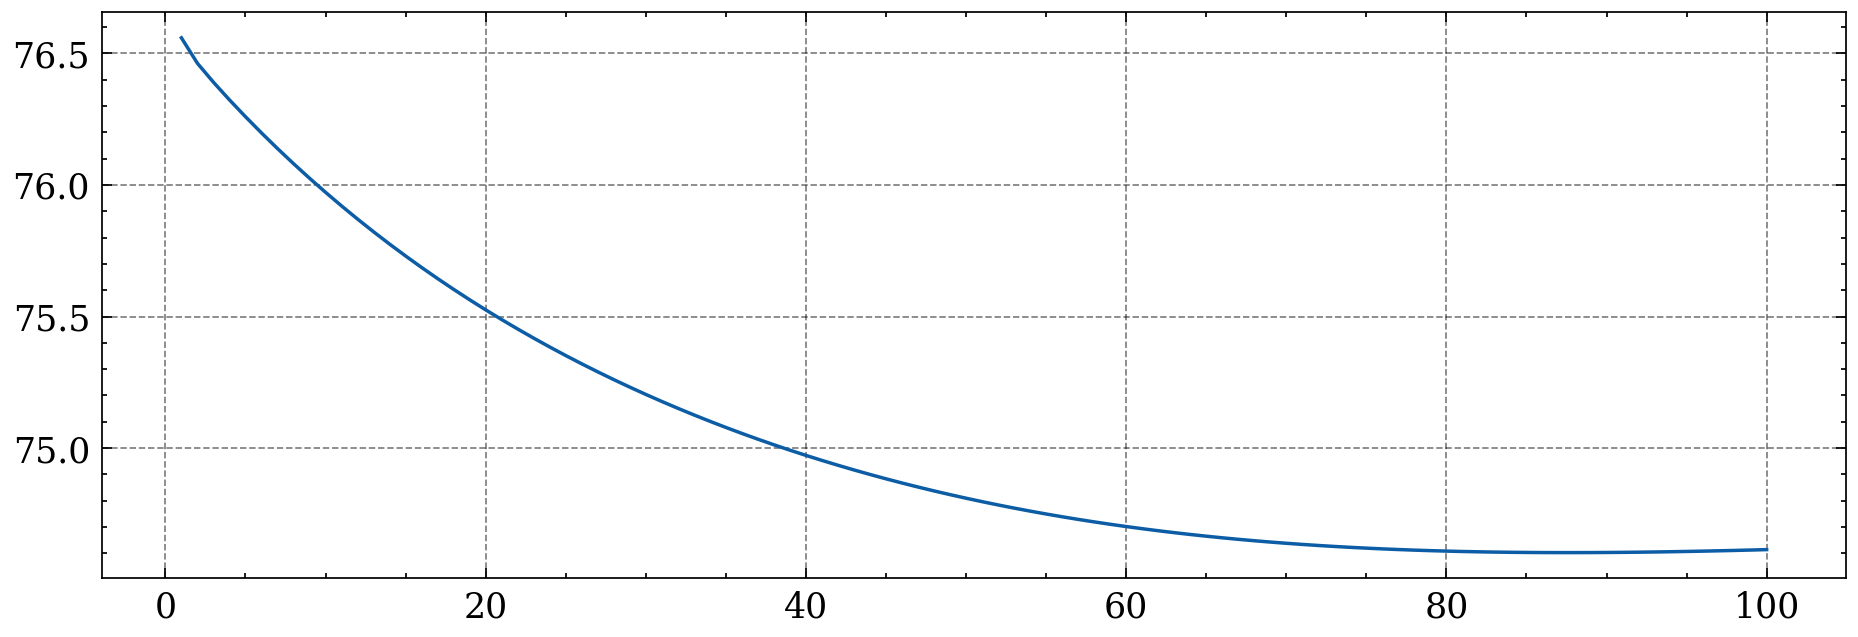

In [ ]:
X = np.arange(1,len(losses[0:-1:int(num_samples/batch_size)])+1,1)
plt.figure(figsize=(9,3),dpi=250)
plt.plot(X, losses[0:-1:int(num_samples/batch_size)])